# Reading Single Day of Data

Getting things set up

In [216]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib as mpl
from bokeh import palettes
from bokeh.charts import Bar
import math
from IPython.display import Image
import datetime as dt

In [270]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [3]:
%matplotlib inline

The below file is a sample day of data stored as an HDF5 file. It can be read as a DataFrame.

In [284]:
day_file = r'/Users/lukestarnes/ADSB/h5/2016-10-01.h5'
mega_file = r'/Users/lukestarnes/ADSB/h5/mega5.h5'

In [285]:
store = pd.HDFStore(mega_file)

In [286]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: /Users/lukestarnes/ADSB/h5/mega5.h5
/data            frame_table  (typ->appendable,nrows->606706,ncols->6,indexers->[index])

**How many rows are in the file?**

In [287]:
store.get_storer('data').nrows

606706

**Read H5 as DF**

In [290]:
store_day = pd.HDFStore(day_file)
day_data_df = store_day.select('data', where=['Lat>=-90','Lat<=90','Long>=-180','Long<=180'])

In [288]:
mega_data_df = store.select('data')

In [291]:
def fx(t):
    try:
        return dt.datetime.fromtimestamp(t / 1000)
    except:
        return 0
mega_data_df['RealTime'] = mega_data_df['PosTime'].fillna(0).map(int).map(fx)
day_data_df['RealTime'] = day_data_df['PosTime'].fillna(0).map(int).map(fx)

**And how many unique aircraft reports?**

In [293]:
len(day_data_df['Icao'].unique()), len(mega_data_df['Icao'].unique())

(8511, 17867)

**How many different Operators and Manufacturers and Types of Aircraft?**

In [296]:
print('Unique Operators:', len(day_data_df['OpIcao'].unique()), 
      ' || Top 5:',list(day_data_df['OpIcao'].value_counts().keys()[:5]))
print('Unique Manufacturers:', len(day_data_df['Man'].unique()), 
      ' || Top 5:',list(day_data_df['Man'].value_counts().keys()[:5]))
print('Unique Type Designatios:', len(day_data_df['Type'].unique()),
      ' || Top 5:',list(day_data_df['Type'].value_counts().keys()[:5]))

Unique Operators: 426  || Top 5: ['SWA', 'AAL', 'UAL', 'DAL', 'JBU']
Unique Manufacturers: 122  || Top 5: ['Boeing', 'Airbus', 'Embraer', 'Bombardier', 'Cessna']
Unique Type Designatios: 288  || Top 5: ['B738', 'A320', 'B737', 'A321', 'A319']


## Airfraft Manufacturers 

**Here are the top aircraft manufacturers.**

In [300]:
ac_by_man = pd.pivot_table(mega_data_df,values=['Icao'],index='Man', 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)
mfr = ac_by_man.index[:10]
print('Total number of manufactuers: %i' % len(ac_by_man))
ac_by_man[:10]

Total number of manufactuers: 211


,Icao
Man,
Boeing,6632
Airbus,5344
Bombardier,1266
Embraer,1013
Cessna,550
Avions de Transport Regional,236
Gulfstream Aerospace,229
McDonnell Douglas,225
Beech,208


In [301]:
plot_df = ac_by_man[:10].sort_values('Icao', ascending=False)
p = Bar(plot_df, label='index', values='Icao', 
        xlabel='Aircraft Manufacturer', ylabel='Number of Aircraft',
        title="Major Aircraft Manufactures", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

In [302]:
ac_by_type = pd.pivot_table(mega_data_df,values=['Icao'],index='Type', 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)
t = ac_by_type.index[:10]
print('Total number of a/c types: %i' % len(ac_by_type))

plot_df = ac_by_type[:10].sort_values('Icao', ascending=False)
print(plot_df)
p = Bar(plot_df, label='index', values='Icao', 
        xlabel='Type Designations', ylabel='Number of Aircraft',
        title="Aircraft Type", width=800, legend=None, 
        tools='pan,wheel_zoom,box_zoom,reset',color='wheat')
p.title.text_font_size = "12pt"
p.xaxis.axis_label_text_font_size = "12pt"
p.yaxis.axis_label_text_font_size = "12pt"
p.xaxis.major_label_text_font = "10pt"
p.yaxis.major_label_text_font = "10pt"
show(p)

Total number of a/c types: 400
      Icao
Type      
B738  2679
A320  2281
A321   905
A319   851
B737   601
B773   565
A333   446
E170   403
A332   382
B763   373


## Airports by Country

Grabed a csv that provides airports (by ICAO name) to county.

In [303]:
airport_codes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', 
                            index_col=0,header=None)
airport_codes.columns = ['Name', 'City', 'Country', 'IATA', 'ICAO', 'Latitude', 
                                     'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz', 'Type', 'Source']
airport_codes.set_index('ICAO',drop=True,inplace=True)
airport_codes.head(3)

,Name,City,Country,IATA,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
ICAO,,,,,,,,,,,,
AYGA,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.08169,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMD,Madang Airport,Madang,Papua New Guinea,MAG,-5.20708,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
AYMH,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.82679,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports


**Construct a dataframe listing the number (and percentage) of each arrival/departure.**

In [80]:
def country_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'Country'].item()
    else:
        return ''

def city_lu(s):
    if s in airport_codes.index: 
        return airport_codes.loc[airport_codes.index == s, 'City'].item()
    else:
        return ''

In [306]:
us_airports = airport_codes[airport_codes['Country'] == 'United States'].index.values
usa_from = day_data_df[day_data_df['From'].isin(us_airports)]
usa_to = day_data_df[day_data_df['To'].isin(us_airports)]
us_airports_df = pd.concat((usa_from, usa_to)).drop_duplicates()

In [307]:
airports = pd.DataFrame()
airports['From'] = day_data_df.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['To'] = day_data_df.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=True)
airports['From'] = airports['From'].fillna(0).map(np.int64)
airports['To'] = airports['To'].fillna(0).map(np.int64)
airports['From (%)'] = airports['From']/airports['From'].sum() * 100
airports['To (%)'] = airports['To']/airports['To'].sum() * 100
airports['From'] = airports['From'].fillna(0)
airports.index.name = 'Airport'
airports.sort_values(by='To',ascending=False).head(20)

,From,To,From (%),To (%)
Airport,,,,
KLAX,158,149,3.874448,3.883242
EGLL,45,123,1.103482,3.205629
KJFK,103,97,2.525748,2.528017
YSSY,66,75,1.618440,1.954652
KMCO,63,72,1.544875,1.876466
KORD,74,69,1.814615,1.798280
RJTT,44,67,1.078960,1.746156
KSFO,75,63,1.839137,1.641908
CYYZ,60,63,1.471309,1.641908


**And here it is grouped by country.**

In [308]:
airport_country = airports.groupby(airports['From']) # 'Country' does not exist in airports obj
if airport_country:
    airport_country.sum().sort_values(by='To',ascending=False).head(20)

**Below is a plot of the top 30 international departure airports.**

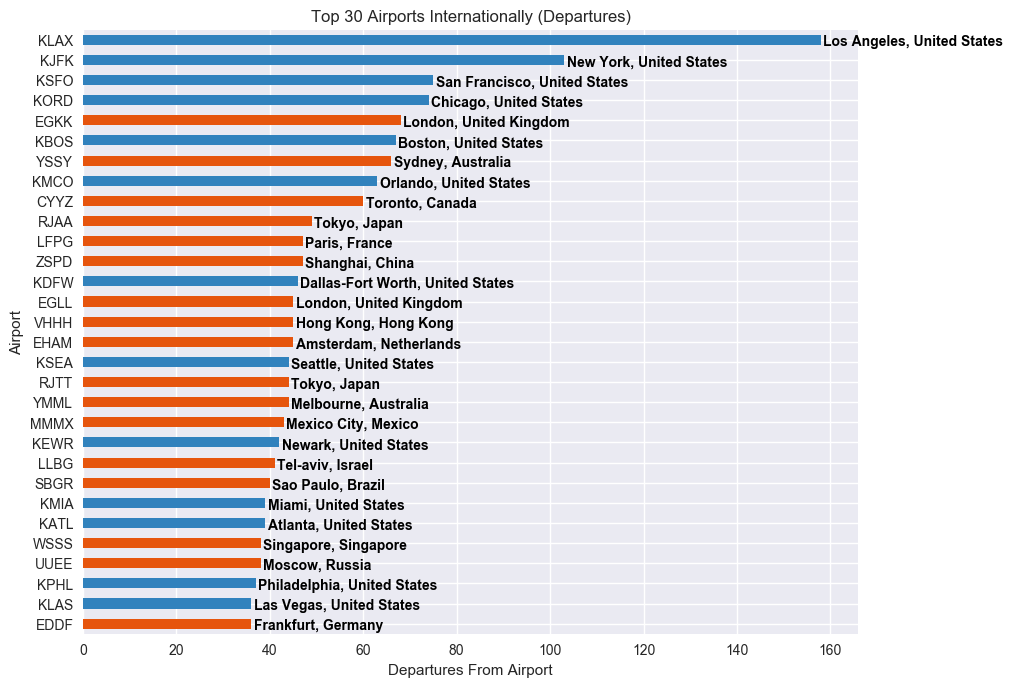

In [309]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh',color=color, title='Top 30 Airports Internationally (Departures)')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .50,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

**Below is a plot of the top 30 international arrival airports.**

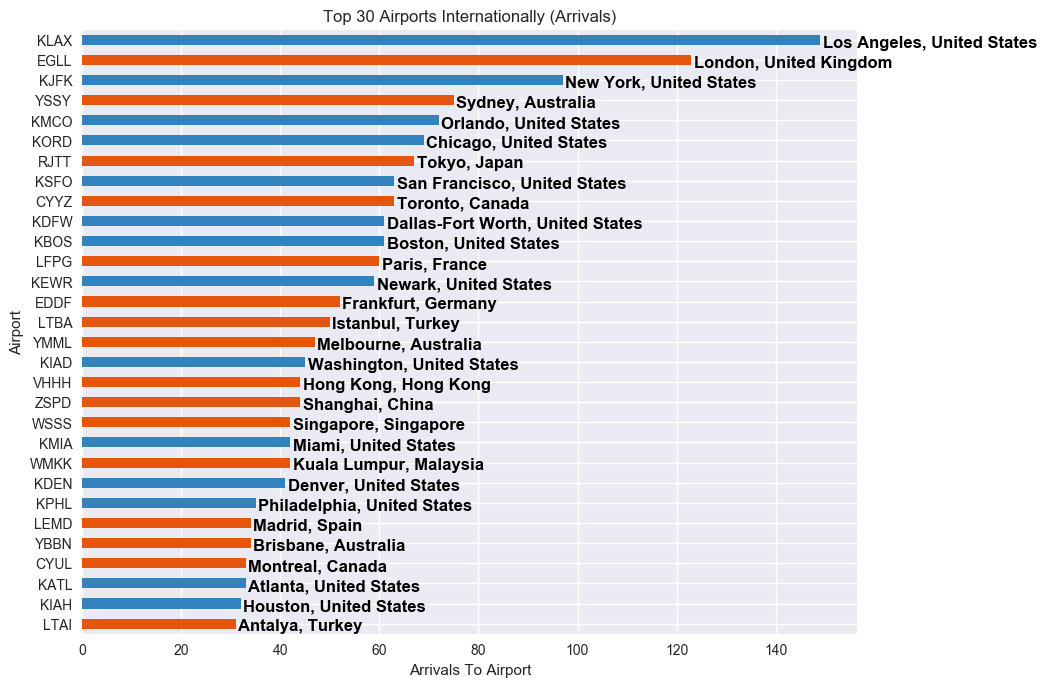

In [310]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = airports.sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports),palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh', color=color, title='Top 30 Airports Internationally (Arrivals)')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
city_countr = [', '.join(s) for s in zip(city,country)] 
rects = ax.patches
for rect, label in zip(rects, city_countr):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=12, ha='left', va='top', weight='heavy')

# Here is similar data for flights that start or stop in the US

In [108]:
usa_airports = pd.DataFrame()
usa_airports['From'] = day_of_data_df.groupby(["From"]).Id.nunique()
usa_airports['To'] = day_of_data_df.groupby(["To"]).Id.nunique()
usa_airports['From'] = usa_airports['From'].fillna(0).map(np.int64)
usa_airports['To'] = usa_airports['To'].fillna(0).map(np.int64)
usa_airports['From (%)'] = usa_airports['From']/usa_airports['From'].sum() * 100
usa_airports['To (%)'] = usa_airports['To']/usa_airports['To'].sum() * 100
usa_airports['Country'] = [country_lu(code) for code in usa_airports.index.values]
usa_airports['Domestic'] = usa_airports.index.isin(us_airports)
usa_airports.index.name = 'Airport'
usa_airports.sort_values(by='To',ascending=False).head(5)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
KLAX,133,148,3.719239,4.479419,United States,True
KJFK,94,101,2.628635,3.056901,United States,True
KSFO,66,89,1.845638,2.693705,United States,True
KORD,62,70,1.733781,2.118644,United States,True
YSSY,54,70,1.510067,2.118644,Australia,False


In [109]:
usa_airports.groupby(usa_airports['Domestic']).sum()

,From,To,From (%),To (%)
Domestic,,,,
False,2074,1888,57.997763,57.142857
True,1502,1416,42.002237,42.857143


The top 30 airports where the destination is in the US.

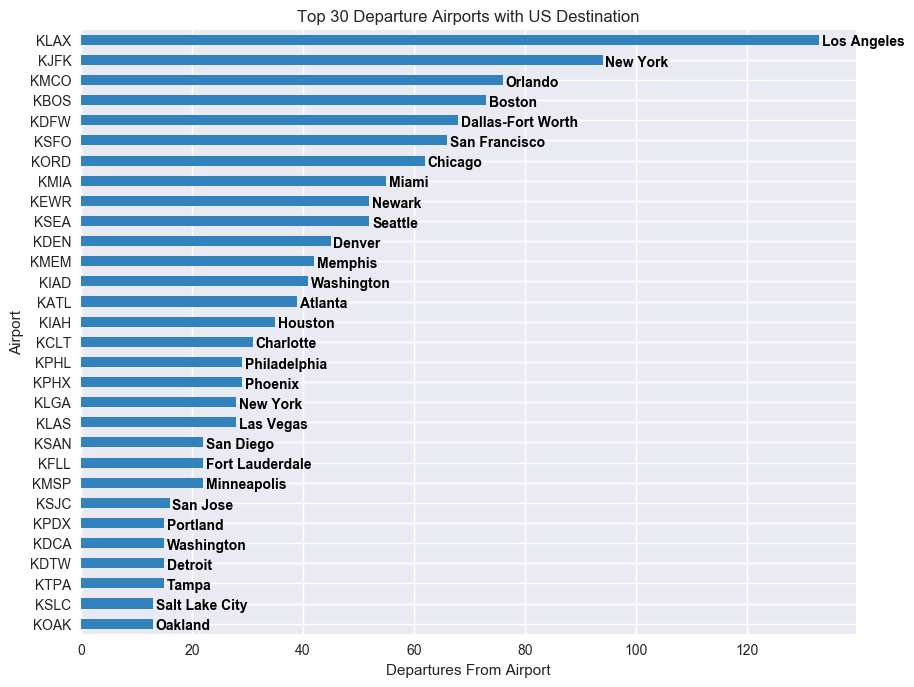

In [114]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.To.index.isin(us_airports)].sort_values(by='From',ascending=False)[:30].sort_values(by='From',ascending=True)
color = np.where(d.index.isin(us_airports),
                 palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['From'].plot(kind='barh', color=color, title='Top 30 Departure Airports with US Destination')
ax.set_xlabel('Departures From Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

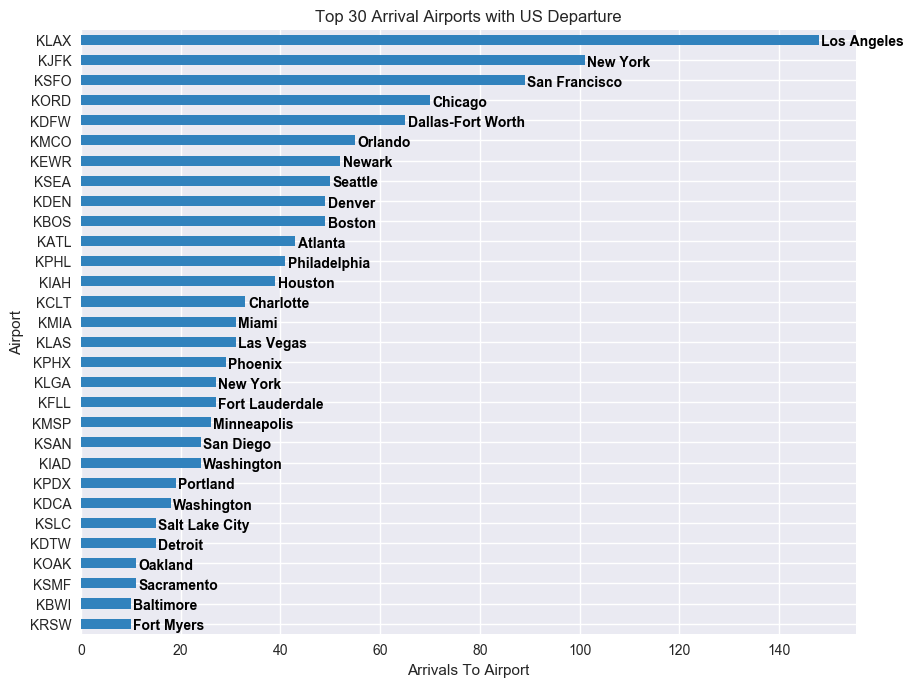

In [115]:
mpl.rcParams['figure.figsize'] = 10, 8
mpl.rcParams['figure.dpi'] = 100
d = usa_airports[usa_airports.From.index.isin(us_airports)].sort_values(by='To',ascending=False)[:30].sort_values(by='To',ascending=True)
color = np.where(d.index.isin(us_airports), palettes.d3['Category20c'][5][0],palettes.d3['Category20c'][5][-1])
ax = d['To'].plot(kind='barh',  color=color, title='Top 30 Arrival Airports with US Departure')
ax.set_xlabel('Arrivals To Airport')
city = [city_lu(code) for code in d.index.values]
country = [country_lu(code) for code in d.index.values]
rects = ax.patches
for rect, label in zip(rects, city):
    width = rect.get_width()
    height = rect.get_height()
    y = rect.get_y()
    ax.text(width + .5,y + height, label, color='black',fontsize=10, ha='left', va='top', weight='heavy')

In [116]:
international = usa_airports[~usa_airports.From.index.isin(us_airports)]
international = international[~international.To.index.isin(us_airports)]
international.sort_values(by='From',ascending=False).head(10)

,From,To,From (%),To (%),Country,Domestic
Airport,,,,,,
EGLL,90,40,2.516779,1.210654,United Kingdom,False
YSSY,54,70,1.510067,2.118644,Australia,False
ZSPD,52,51,1.454139,1.543584,China,False
YMML,50,43,1.398210,1.301453,Australia,False
CYYZ,47,51,1.314318,1.543584,Canada,False
WSSS,44,28,1.230425,0.847458,Singapore,False
ZBAA,42,46,1.174497,1.392252,China,False
RJTT,42,30,1.174497,0.907990,Japan,False
VHHH,38,46,1.062640,1.392252,Hong Kong,False


In [117]:
international_country = international.groupby(international['Country'])
print('Main contries traveled to:\n',', '.join(list(international_country.sum().sort_values(by='To',
                                                                                 ascending=False).head(20).index)))
print('Main countries traveled from:\n', ', '.join(list(international_country.sum().sort_values(by='From',
                                                                                   ascending=False).head(20).index)))

Main contries traveled to:
 China, Australia, Canada, Japan, Brazil, United Kingdom, Mexico, Russia, Germany, Hong Kong, New Zealand, United Arab Emirates, France, Malaysia, Colombia, Netherlands, Indonesia, South Korea, Italy, Singapore
Main countries traveled from:
 China, Australia, United Kingdom, Canada, Brazil, Japan, Mexico, Spain, Germany, Russia, Malaysia, Singapore, United Arab Emirates, Italy, France, Hong Kong, New Zealand, Taiwan, Turkey, Indonesia


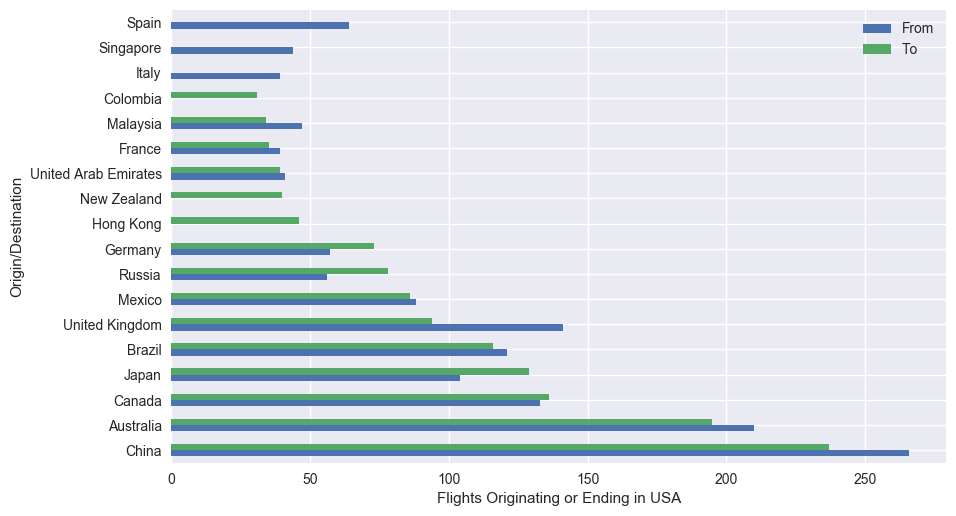

In [311]:
mpl.rcParams['figure.figsize'] = 10, 6
mpl.rcParams['figure.dpi'] = 100
from_ = international_country.sum().sort_values(by='From',ascending=False).head(15)['From']
to_ = international_country.sum().sort_values(by='To',ascending=False).head(15)['To']
ax = pd.concat([from_, to_], axis=1).sort_values(by='To',ascending=False).plot(kind='barh')
ax.set_xlabel('Flights Originating or Ending in USA')
ax.set_ylabel('Origin/Destination')

And Atlanta...

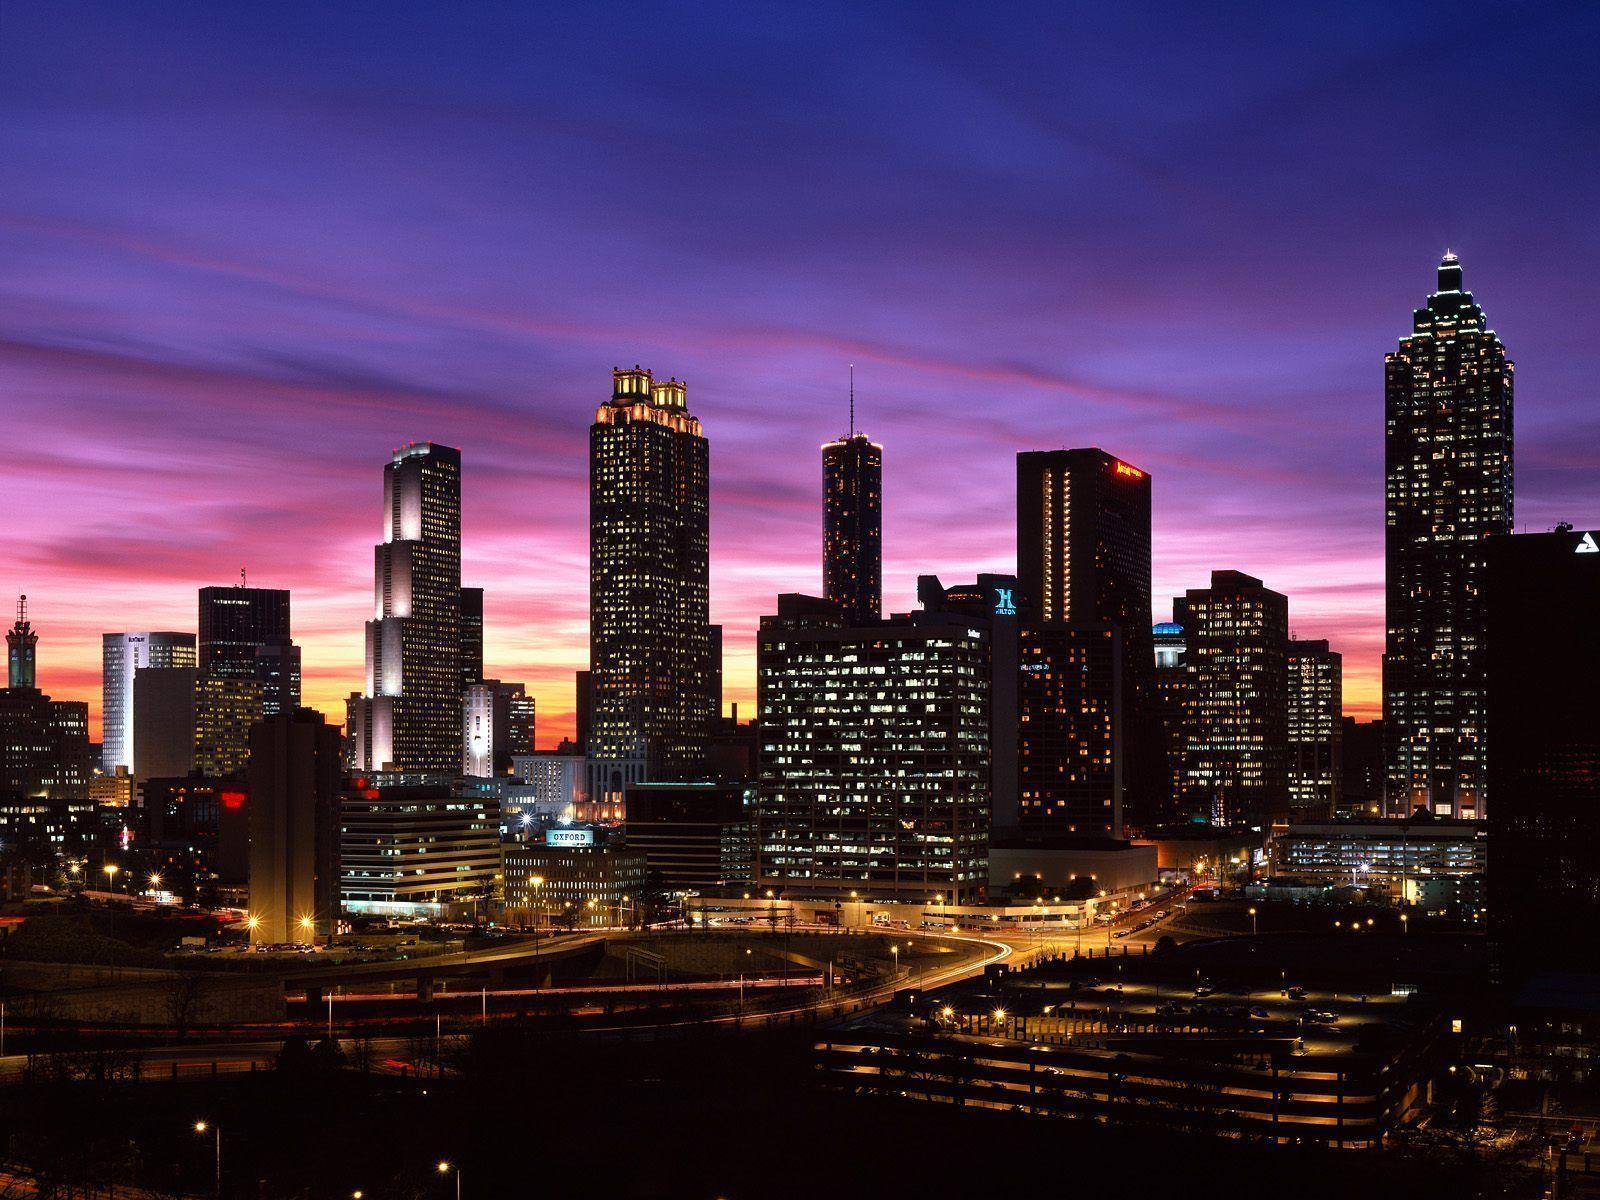

In [119]:
Image("http://wallpapercave.com/wp/E48LtWF.jpg")

In [312]:
# atl_ = store.select('data',where='From = "KATL" | To = "KATL"').drop_duplicates()
atl_ = day_data_df.query('From == "KATL" | To == "KATL"')
atl = pd.DataFrame()
atl['From'] = atl_.groupby(["To"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['To'] = atl_.groupby(["From"]).Id.nunique().sort_values(ascending=False).sort_values(ascending=False)
atl['From'] = atl['From'].fillna(0).map(np.int64)
atl['To'] = atl['To'].fillna(0).map(np.int64)
atl['From (%)'] = atl['From']/atl['From'].sum() * 100
atl['To (%)'] = atl['To']/atl['To'].sum() * 100
atl['Country'] = [country_lu(code) for code in atl.index.values]
atl.drop('KATL', inplace=True)
atl['Both'] = atl['From'] + atl['To']
atl = atl.sort_values(by='Both',ascending=False).head(15)
atl

,From,To,From (%),To (%),Country,Both
To,,,,,,
KLAX,2,2,3.076923,4.545455,United States,4
EGLL,1,2,1.538462,4.545455,United Kingdom,3
KSLC,1,2,1.538462,4.545455,United States,3
KSFO,2,1,3.076923,2.272727,United States,3
EDDF,2,0,3.076923,0.000000,Germany,2
KCLT,2,0,3.076923,0.000000,United States,2
KMCO,1,1,1.538462,2.272727,United States,2
MMMX,1,1,1.538462,2.272727,Mexico,2
KONT,1,1,1.538462,2.272727,United States,2


In [313]:
day_of_data_df_ATL = day_of_data_df.query("To == 'KATL' | From == 'KATL'")
ac_in_ATL = pd.pivot_table(day_of_data_df_ATL,values=['Icao'],index=['Man','Type'], 
                           aggfunc=lambda x: len(x.unique())).sort_values(by='Icao',ascending=False)

In [315]:
ac_by_man[:10]

,Icao
Man,
Boeing,6632
Airbus,5344
Bombardier,1266
Embraer,1013
Cessna,550
Avions de Transport Regional,236
Gulfstream Aerospace,229
McDonnell Douglas,225
Beech,208
